# Backpropagation exercise
In the previous homework, you implemented a softmax classifier on mnist. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple one-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer typess in isolation and then snap them together into models with different architectures.

In this exercise we will implemtn fully-connected networks using a more modular approach. For each layer we will implement a <code>forward</code> and a <code>backward</code> function. The <code>forward</code> function will receive inputs, weights, and other parameters and will return both an output and a <code>cache</code> object storing data needed for the backward pass like this:

```python
def layer_forward(x, w):
    """ Receive inputs x and weights w """
    # Do some computations ...
    z = # ... sime intermediate value
    # Do some more computations ...
    out = # the output
    
    cache = (x, w, z, out) # Values we need to compute gradients
    return (out, cache)
```

The backward pass will receive upstream derivatives and the <code>cache</code> object, and will return gradients with respect to the input and weights like this:

```python
def layer_backward(dout, cache):
    """
    Receive derivative of loss with respect to outputs and cache, and compute derivative with respect to inputs.
    """
    # Unpack cache values
    x, w, z, out = cache
    
    # Use values in cache to compute derivatives
    dx = # Derivative of loss with respect to x
    dw = # Derivative of loss with respect to w
    
    return dx, dw
```

After implementing a bunch of layers this way,we will be able to easily combine them to build classifiers with different architectures.

In addition to implement fully-connected networks of arbitrary depth, we will also explore different update rules for optimization.

In [1]:
from keras.datasets import fashion_mnist
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import numpy as np

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

Using TensorFlow backend.


In [2]:
nb_classes = 10
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

#############################################################################
# TODO: Print the shape of the training data and testing data               #
# Plot the previous 9 training data and title their class name              #
# Count the number of data for each class in training data                  #
#############################################################################
print("X_train original shape {}".format(X_train.shape))
print("y_train original shape {}".format(y_train.shape))
print("X_test original shape {}".format(X_test.shape))
print("y_test original shape {}".format(y_test.shape))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i], cmap = 'gray', interpolation = 'none')
    plt.title("Class {}".format(class_names[y_train[i]]))
plt.tight_layout()

unique, count = np.unique(y_train, return_counts = True)
cls_count = np.concatenate((unique.reshape(nb_classes, 1), count.reshape(nb_classes, 1)), axis = 1)
print('class\tcount')
print('\n'.join(['{}\t{}'.format(item[0], item[1]) for item in cls_count]))
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

X_train original shape (60000, 28, 28)
y_train original shape (60000,)
X_test original shape (10000, 28, 28)
y_test original shape (10000,)
class	count
0	6000
1	6000
2	6000
3	6000
4	6000
5	6000
6	6000
7	6000
8	6000
9	6000


In [3]:
# data prepration for binary classification
not_n = 6
def get_binary_data(X_train, y_train, X_test, y_test):
    
    # normalization
    X_train = X_train / 255.
    X_test = X_test / 255.
    
    # reshape
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # binarize
    y_train[y_train != not_n] = 0.
    y_train[y_train == not_n] = 1.
    y_test[y_test != not_n] = 0.
    y_test[y_test == not_n] = 1.

    X = np.array(X_train)
    y = np.array(y_train)
    
    # split train and validation
    sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.5, random_state = 0)
    for train_idx, val_idx in sss.split(X_train, y_train):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
    
    X_train, y_train = subsampling(X_train, y_train)
    X_val, y_val = subsampling(X_val, y_val)
    X_test, y_test = subsampling(X_test, y_test)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

def subsampling(X, y):
    unique, count = np.unique(y, return_counts = True)
    n_sampling = count[np.argmin(count)]
    
    idx_list = []
    for i in range(len(unique)):
        if count[i] <= n_sampling:
            idx_list.append(np.where(y == unique[i])[0])
            continue
        idx = np.where(y == unique[i])[0]
        idx = np.random.choice(idx, n_sampling, replace = False)
        idx_list.append(idx)
    
    all_idx = np.sort(np.concatenate(idx_list))
    X_sub = X[all_idx]
    y_sub = y[all_idx]
    
    return X_sub, y_sub

# Invoke the above function to get our data
X_train, y_train, X_val, y_val, X_test, y_test = get_binary_data(X_train, y_train, X_test, y_test)
print('Train data shape: {}'.format(X_train.shape))
print('Train label shape: {}'.format(y_train.shape))
print('Validation data shape: {}'.format(X_val.shape))
print('Validation label shape: {}'.format(y_val.shape))
print('Test data shape: {}'.format(X_test.shape))
print('Test label shape: {}'.format(y_test.shape))

Train data shape: (6000, 28, 28)
Train label shape: (6000,)
Validation data shape: (6000, 28, 28)
Validation label shape: (6000,)
Test data shape: (2000, 28, 28)
Test label shape: (2000,)


# Affine layer: forward
Implement the <code>affine_forward</code> function.

In [5]:
def affine_forward(x, w, b, a):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)
    - a: A function of activation

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    ###########################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You   #
    # will need to reshape the input into rows.                               #
    ###########################################################################
    x_reshape = x.reshape((x.shape[0], np.product(x.shape[1:])))
    z = np.dot(x_reshape, w) + b
    out = a(z)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = ((x, w, b), (z))
    return out, cache

# Test the affine_forward function
num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num = input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num = weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num = output_dim)

a = lambda x: x # linear activation
out, _ = affine_forward(x, w, b, a)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: {}'.format(rel_error(out, correct_out)))

Testing affine_forward function:
difference: 9.76985004799e-10


# Affine layer: backward
Now implement the <code>affine_backward</code> function and test your implementation using numeric gradient checking.

In [6]:
def affine_backward(dout, da, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - da: A function of the derivative of the activation
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    fc_cache, act_cache = cache
    x, w, b = fc_cache
    z = act_cache
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    dz = da(z) * dout
    dx = np.dot(dz, w.T).reshape(x.shape)
    x_reshape = x.reshape(x.shape[0], np.product(x.shape[1:]))
    dw = np.dot(x_reshape.T, dout)
    db = dout.sum(axis = 0)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags = ['multi_index'], op_flags = ['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b, a)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b, a)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b, a)[0], b, dout)

_, cache = affine_forward(x, w, b, a)
da = lambda x: 1 # the derivative of linear activation
dx, dw, db = affine_backward(dout, da, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: {}'.format(rel_error(dx_num, dx)))
print('dw error: {}'.format(rel_error(dw_num, dw)))
print('db error: {}'.format(rel_error(db_num, db)))

Testing affine_backward function:
dx error: 6.98634850437e-11
dw error: 9.90402358399e-11
db error: 7.73697883449e-12


# Two-layer network
Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Complete the implementation of the <code>TwoLayerNet</code> class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [7]:
# http://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html
acts = {'relu': lambda x: np.maximum(x, 0., x),
       'tanh': lambda x: np.tanh(x),
       'sigmoid': lambda x: 1 / (1 + np.exp(- x)),
       'leaky_relu': lambda x: np.maximum(x, 0.01 * x, x)} # here alpha = 0.01
dacts = {'relu': lambda x: np.greater(x, 0),
        'tanh': lambda x: (1 - (x ** 2)),
        'sigmoid': lambda x: x * (1 - x),
        'leaky_relu': lambda x: np.greater(x, 0) * (1 - 0.01) + 0.01}

def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    shifted_logits = x - np.max(x, axis = 1, keepdims = True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims = True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = x.shape[0]
    loss = - np.sum(log_probs[np.arange(N), y]) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx

class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim = 28 * 28, hidden_dim = 100, num_classes = 10,
                 weight_scale = 1e-3, reg = 0.0, act = (acts['relu'], dacts['relu'])):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - dropout: Scalar between 0 and 1 giving dropout strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg
        self.act = act

        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian with standard deviation equal to   #
        # weight_scale, and biases should be initialized to zero. All weights and  #
        # biases should be stored in the dictionary self.params, with first layer  #
        # weights and biases using the keys 'W1' and 'b1' and second layer weights #
        # and biases using the keys 'W2' and 'b2'.                                 #
        ############################################################################
        self.params['W1'] = np.random.randn(input_dim, hidden_dim) * weight_scale
        self.params['b1'] = np.zeros((hidden_dim))
        self.params['W2'] = np.random.randn(hidden_dim, num_classes) * weight_scale
        self.params['b2'] = np.zeros((num_classes))
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################


    def loss(self, X, y = None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        out_1, cache_1 = affine_forward(X, self.params['W1'], self.params['b1'], self.act[0])
        
        out_2, cache_2 = affine_forward(out_1, self.params['W2'], self.params['b2'], self.act[0])
        scores = out_2
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization!                   #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        data_loss, dout_2 = softmax_loss(scores, y)
        reg_loss = 0.5 * self.reg * (np.sum(self.params['W1'] ** 2) + np.sum(self.params['W2'] ** 2))
        loss = data_loss + reg_loss
        dout_1, grads['W2'], grads['b2'] = affine_backward(dout_2, self.act[1], cache_2)
        grads['W2'] += self.reg * 0.5 * self.params['W2']
        
        _, grads['W1'], grads['b1'] = affine_backward(dout_1, self.act[1], cache_1)
        grads['W1'] += self.reg * 0.5 * self.params['W1']
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size = N)

std = 1e-3
model = TwoLayerNet(input_dim = D, hidden_dim = H, num_classes = C, weight_scale = std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num = D * H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num = H)
model.params['W2'] = np.linspace(-0.3, 0.4, num = H * C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num = C)
X = np.linspace(-5.5, 4.5, num = N * D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
if abs(loss - correct_loss) >= 1e-10:
    print('Problem with regularization loss')

for reg in [0.0, 0.7]:
    print('Running numeric gradient check with reg = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose = False)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
('Running numeric gradient check with reg = ', 0.0)
W1 relative error: 2.13e-08
W2 relative error: 3.31e-10
b1 relative error: 8.37e-09
b2 relative error: 2.53e-10
('Running numeric gradient check with reg = ', 0.7)
W1 relative error: 1.00e+00
W2 relative error: 1.00e+00
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Read through it to familiarize yourself with the API. After doing so, use a <code>Solver</code> instance to train a <code>TwoLayerNet</code> that achieves at least <code>50%</code> accuracy on the validation set.

(Iteration 1 / 1200) loss: 2.302614
(Epoch 0 / 20) train acc: 0.510000; val_acc: 0.500000
(Epoch 1 / 20) train acc: 0.507000; val_acc: 0.500000
(Iteration 101 / 1200) loss: 0.522562
(Epoch 2 / 20) train acc: 0.766000; val_acc: 0.765833
(Epoch 3 / 20) train acc: 0.539000; val_acc: 0.532000
(Iteration 201 / 1200) loss: 0.455321
(Epoch 4 / 20) train acc: 0.794000; val_acc: 0.776833
(Epoch 5 / 20) train acc: 0.774000; val_acc: 0.783667
(Iteration 301 / 1200) loss: 0.587341
(Epoch 6 / 20) train acc: 0.846000; val_acc: 0.812667
(Iteration 401 / 1200) loss: 0.310829
(Epoch 7 / 20) train acc: 0.792000; val_acc: 0.806833
(Epoch 8 / 20) train acc: 0.840000; val_acc: 0.826167
(Iteration 501 / 1200) loss: 0.261233
(Epoch 9 / 20) train acc: 0.847000; val_acc: 0.841667
(Epoch 10 / 20) train acc: 0.797000; val_acc: 0.798667
(Iteration 601 / 1200) loss: 0.477947
(Epoch 11 / 20) train acc: 0.824000; val_acc: 0.831167
(Iteration 701 / 1200) loss: 0.300117
(Epoch 12 / 20) train acc: 0.842000; val_acc: 0.

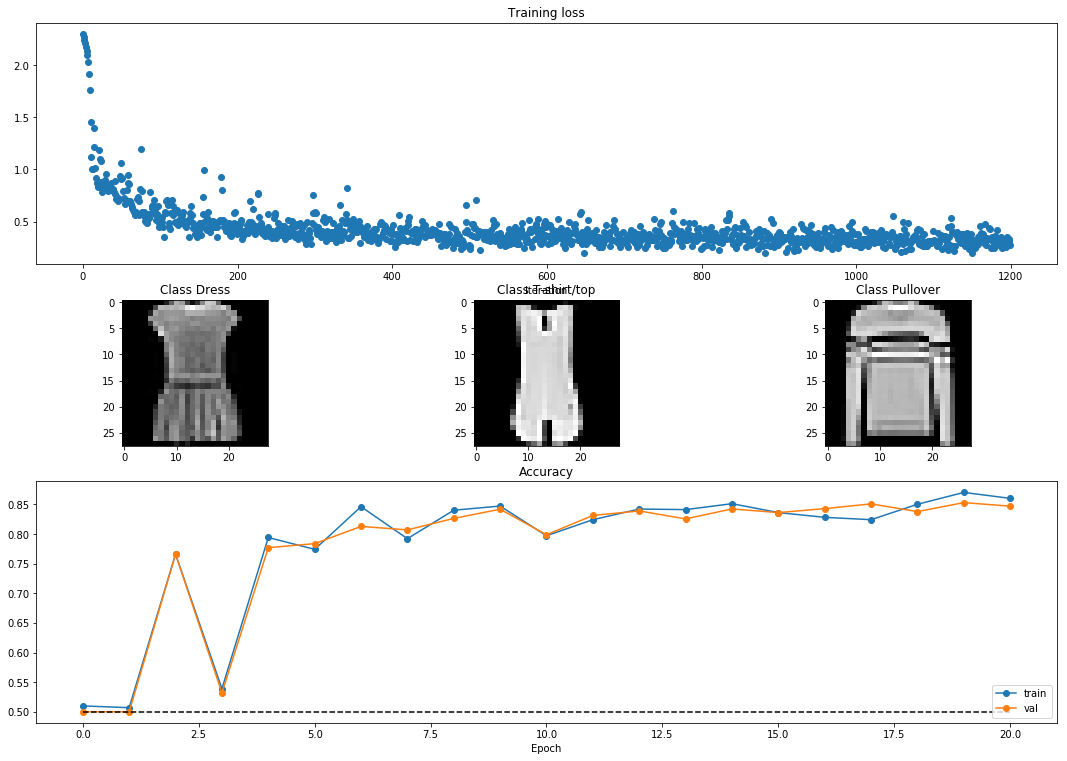

In [8]:
def sgd(w, dw, config = None):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw
    return w, config

class Solver(object):
    """
    A Solver encapsulates all the logic necessary for training classification
    models. The Solver performs stochastic gradient descent using different
    update rules defined in optim.py.

    The solver accepts both training and validataion data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, you will first construct a Solver instance, passing the
    model, dataset, and various optoins (learning rate, batch size, etc) to the
    constructor. You will then call the train() method to run the optimization
    procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists of the
    accuracies of the model on the training and validation set at each epoch.

    Example usage might look something like this:

    data = {
      'X_train': # training data
      'y_train': # training labels
      'X_val': # validation data
      'y_val': # validation labels
    }
    model = MyAwesomeModel(hidden_size=100, reg=10)
    solver = Solver(model, data,
                    update_rule = 'sgd',
                    optim_config = {
                      'learning_rate': 1e-3,
                    },
                    lr_decay = 0.95,
                    num_epochs = 10, batch_size = 100,
                    print_every = 100)
    solver.train()


    A Solver works on a model object that must conform to the following API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(X, y) must be a function that computes training-time loss and
      gradients, and test-time classification scores, with the following inputs
      and outputs:

      Inputs:
      - X: Array giving a minibatch of input data of shape (N, d_1, ..., d_k)
      - y: Array of labels, of shape (N,) giving labels for X where y[i] is the
        label for X[i].

      Returns:
      If y is None, run a test-time forward pass and return:
      - scores: Array of shape (N, C) giving classification scores for X where
        scores[i, c] gives the score of class c for X[i].

      If y is not None, run a training time forward and backward pass and
      return a tuple of:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new Solver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data containing:
          'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
          'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
          'y_train': Array, shape (N_train,) of labels for training images
          'y_val': Array, shape (N_val,) of labels for validation images

        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the
          learning rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient
          during training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every
          print_every iterations.
        - verbose: Boolean; if set to false then no output will be printed
          during training.
        - num_train_samples: Number of training samples used to check training
          accuracy; default is 1000; set to None to use entire training set.
        - num_val_samples: Number of validation samples to use to check val
          accuracy; default is None, which uses the entire validation set.
        - checkpoint_name: If not None, then save model checkpoints here every
          epoch.
        """
        self.model = model
        self.X_train = data['X_train']
        self.y_train = data['y_train']
        self.X_val = data['X_val']
        self.y_val = data['y_val']

        # Unpack keyword arguments
        self.update_rule = kwargs.pop('update_rule', 'sgd')
        self.optim_config = kwargs.pop('optim_config', {})
        self.lr_decay = kwargs.pop('lr_decay', 1.0)
        self.batch_size = kwargs.pop('batch_size', 100)
        self.num_epochs = kwargs.pop('num_epochs', 10)
        self.num_train_samples = kwargs.pop('num_train_samples', 1000)
        self.num_val_samples = kwargs.pop('num_val_samples', None)

        self.checkpoint_name = kwargs.pop('checkpoint_name', None)
        self.print_every = kwargs.pop('print_every', 10)
        self.verbose = kwargs.pop('verbose', True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError('Unrecognized arguments %s' % extra)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        if not globals()[self.update_rule]:
            raise ValueError('Invalid update_rule "%s"' % self.update_rule)
        self.update_rule = globals()[self.update_rule]

        self._reset()


    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d


    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config


    def _save_checkpoint(self):
        if self.checkpoint_name is None: return
        checkpoint = {
          'model': self.model,
          'update_rule': self.update_rule,
          'lr_decay': self.lr_decay,
          'optim_config': self.optim_config,
          'batch_size': self.batch_size,
          'num_train_samples': self.num_train_samples,
          'num_val_samples': self.num_val_samples,
          'epoch': self.epoch,
          'loss_history': self.loss_history,
          'train_acc_history': self.train_acc_history,
          'val_acc_history': self.val_acc_history,
        }
        filename = '%s_epoch_%d.pkl' % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, 'wb') as f:
            pickle.dump(checkpoint, f)


    def check_accuracy(self, X, y, num_samples = None, batch_size = 100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using
          too much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis = 1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc


    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print('(Iteration %d / %d) loss: %f' % (
                       t + 1, num_iterations, self.loss_history[-1]))

            # At the end of every epoch, increment the epoch counter and decay
            # the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]['learning_rate'] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = (t == 0)
            last_it = (t == num_iterations - 1)
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(self.X_train, self.y_train,
                    num_samples=self.num_train_samples)
                val_acc = self.check_accuracy(self.X_val, self.y_val,
                    num_samples=self.num_val_samples)
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()

                if self.verbose:
                    print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (
                           self.epoch, self.num_epochs, train_acc, val_acc))

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params

data = {
    'X_train': X_train, # training data
    'y_train': y_train, # training labels
    'X_val': X_val, # validation data
    'y_val': y_val, # validation data
}
        
model = TwoLayerNet()
solver = Solver(model, data,
               update_rule = 'sgd',
               optim_config = {
                   'learning_rate': 1e-1,
               },
               lr_decay = 0.95,
               num_epochs = 20,
               batch_size = 100,
               print_every = 100)

solver.train()

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [9]:
# Use the validation set to tune hyperparameters (activation functions and
# hidden dimensions). You should experiment with different ranges for the hidden
# dimensions and activations; if you are careful you should be able to
# get a classification accuracy of over 0.8 on the validation set.
results = {}
best_val = -1
best_solver = None
hidden_dims = [50, 100, 200]
activations = ['relu', 'leaky_relu', 'tanh', 'sigmoid']
data = {
    'X_train': X_train, # training data
    'y_train': y_train, # training labels
    'X_val': X_val, # validation data
    'y_val': y_val, # validation data
}

################################################################################
# TODO:                                                                        #
# Use the validation set to set the hidden_dimension and activation.           #
# save the best trained solver in best_solver.                                 #
################################################################################
for dim in hidden_dims:
    for act in activations:
        model = TwoLayerNet(hidden_dim = dim, act = (acts[act], dacts[act]))
        solver = Solver(model, 
                        data,
                        update_rule = 'sgd',
                        optim_config = {
                            'learning_rate': 1e-2,
                        },
                        lr_decay = 0.98,
                        num_epochs = 30,
                        batch_size = 200,
                        print_every = 100, 
                        verbose = False)

        solver.train()
        val_acc = solver.check_accuracy(X_val, y_val)
        if val_acc > best_val:
          best_val = val_acc
          best_solver = solver
        results[(dim, act)] = val_acc
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

hidden dims 5.000000e+01 activation leaky_relu val accuracy: 0.782667
hidden dims 5.000000e+01 activation relu val accuracy: 0.782833
hidden dims 5.000000e+01 activation sigmoid val accuracy: 0.532500
hidden dims 5.000000e+01 activation tanh val accuracy: 0.633833
hidden dims 1.000000e+02 activation leaky_relu val accuracy: 0.782667
hidden dims 1.000000e+02 activation relu val accuracy: 0.783333
hidden dims 1.000000e+02 activation sigmoid val accuracy: 0.540000
hidden dims 1.000000e+02 activation tanh val accuracy: 0.532167
hidden dims 2.000000e+02 activation leaky_relu val accuracy: 0.783333
hidden dims 2.000000e+02 activation relu val accuracy: 0.782667
hidden dims 2.000000e+02 activation sigmoid val accuracy: 0.500000
hidden dims 2.000000e+02 activation tanh val accuracy: 0.558833
best validation accuracy achieved during cross-validation: 0.783333


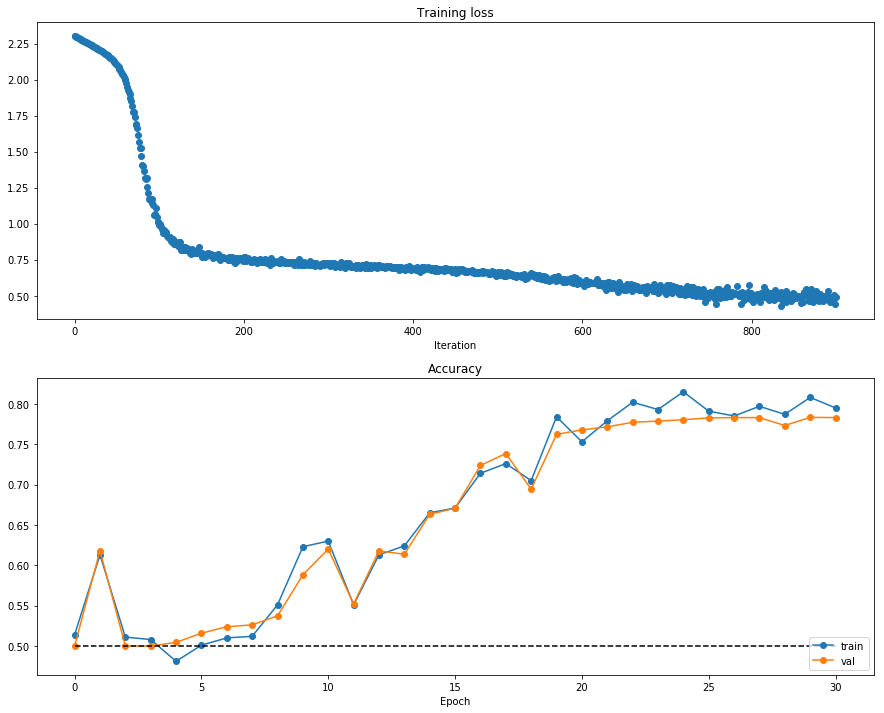

model on raw pixels final test set accuracy: 0.500000


In [11]:
# Print out results.
for dim, act in sorted(results):
    val_accuracy = results[(dim, act)]
    print('hidden dims %e activation %s val accuracy: %f' % (
                dim, act, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(best_solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(best_solver.train_acc_history, '-o', label='train')
plt.plot(best_solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(best_solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# evaluate the best softmax on test set
test_accuracy = solver.check_accuracy(X_test, y_test)
print('model on raw pixels final test set accuracy: %f' % (test_accuracy, ))